In [11]:
from sonarlight import Sonar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from PIL import Image
import time

In [ ]:
# config
resolution = 0.02 # Specify an output pixel resolution [in meters] "0.02m per pixel"

In [3]:
start_time = time.time()
print("Reading sonar file...")
sonar = Sonar("examples/Sonar_2023-09-13_12.20.32.sl2", augment_coords=True)
print("Time (s):", round(time.time() - start_time, ndigits=1))

Reading sonar file...
Time (s): 7.9


In [4]:
sonar

Summary of SL2 file:

- Primary channel with 4252 frames
- Downscan channel with 4252 frames
- Sidescan channel with 4251 frames

Start time: 2023-09-13 05:05:36.505000114
End time: 2023-09-13 05:12:46.365000010

File info: version 2, device 2, blocksize 3200, frame version 8

In [3]:
sonar.df["frames"][0].shape

(3072,)

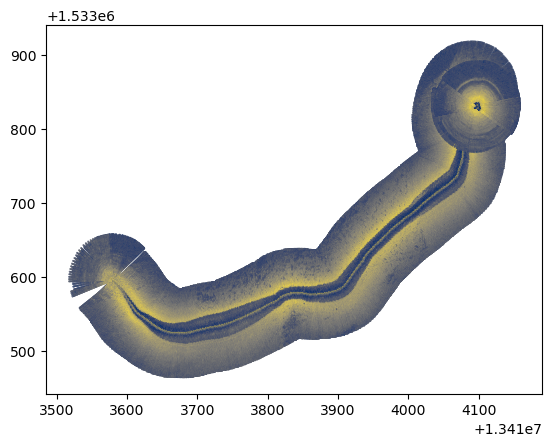

In [163]:
# Plot sidescan georeferenced points
# Convert sidescan imagery to XYZ point cloud
# Note that this can result in MANY points, every 10'th point are plotted here
mosaic = sonar.sidescan_xyz()
plt.scatter(mosaic.x[::10], 
            mosaic.y[::10], 
            c=mosaic.z[::10], 
            cmap="cividis", s=0.05)

In [5]:
data = sonar.df.query(f"survey == 'sidescan'")
dist = [np.linspace(start, stop, num = len(f)) for start, stop, f in zip(data["min_range"], 
                                                                            data["max_range"], 
                                                                            data["frames"])]
dist_stack = np.stack(dist)
sidescan_z = sonar.image("sidescan")

#sidescan_x = np.expand_dims(data["x_augmented"], axis=1) + dist_stack * np.cos(np.expand_dims(data["gps_heading"], axis=1))
#sidescan_y = np.expand_dims(data["y_augmented"], axis=1) - dist_stack * np.sin(np.expand_dims(data["gps_heading"], axis=1))
sidescan_x = np.expand_dims(data["x"], axis=1) + dist_stack * np.cos(np.expand_dims(data["gps_heading"], axis=1))
sidescan_y = np.expand_dims(data["y"], axis=1) - dist_stack * np.sin(np.expand_dims(data["gps_heading"], axis=1))

sidescan_long = sonar._x2lon(sidescan_x)
sidescan_lat = sonar._y2lat(sidescan_y)


In [31]:
# Used to adjust values to the correct pixel coordinates
min_x = np.min(sidescan_x)
min_y = np.min(sidescan_y)

print(min_x, min_y)

13413516.992516056 1533463.985046905


In [32]:
# Scale the coordinates to pixel values
# And adjust by resolution
# Lastly, convert to integers
resolution = 1
sidescan_x_scaled = ((sidescan_x - min_x) / resolution).astype(int)
sidescan_y_scaled = ((sidescan_y - min_y) / resolution).astype(int)

# first 5
print(sidescan_x_scaled[:5])
print(sidescan_y_scaled[:5])

[[122 122 122 ...   8   7   7]
 [122 122 122 ...   7   7   7]
 [123 123 123 ...   7   6   6]
 [123 123 123 ...   6   6   6]
 [124 124 124 ...   5   5   5]]
[[152 152 152 ... 115 115 115]
 [150 150 150 ... 117 117 117]
 [149 149 149 ... 118 118 118]
 [145 145 145 ... 122 122 122]
 [141 141 141 ... 126 126 126]]


In [33]:
# Determine the width and height of the image from scaled by resolution
min_x_scaled = np.min(sidescan_x_scaled)
max_x_scaled = np.max(sidescan_x_scaled)
min_y_scaled = np.min(sidescan_y_scaled)
max_y_scaled = np.max(sidescan_y_scaled)

width = max_x_scaled - min_x_scaled
height = max_y_scaled - min_y_scaled

print(width, height)

642 454


In [34]:
# Clip coordinates to ensure they are within the bounds of the image
# Because pixel coordinates starts at 0
sidescan_x_scaled = np.clip(sidescan_x_scaled, 0, width - 1)
sidescan_y_scaled = np.clip(sidescan_y_scaled, 0, height - 1)

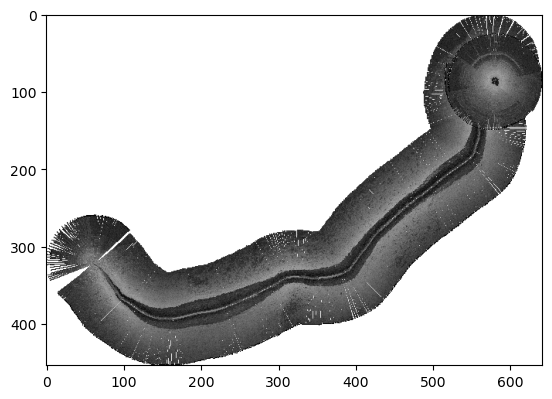

In [41]:
# Create a transparent RGBA image using Pillow
# We want transparent images.
image_data = np.zeros((height, width, 4), dtype=np.uint8)

# Assign pixel values
image_data[sidescan_y_scaled, sidescan_x_scaled, 0] = sidescan_z  # Red channel
image_data[sidescan_y_scaled, sidescan_x_scaled, 1] = sidescan_z  # Green channel
image_data[sidescan_y_scaled, sidescan_x_scaled, 2] = sidescan_z  # Blue channel
image_data[sidescan_y_scaled, sidescan_x_scaled, 3] = 255  # Alpha channel (fully opaque)

# since x y coordinate are actually starts bottom left, while image application of pixel coordinates starts from top left, we fix the orientation
image_data = np.flipud(image_data)

# Create a Pillow image from the NumPy array
image = Image.fromarray(image_data, 'RGBA')

# Save the image as PNG with transparency
image_path = "sidescan.png"
image.save(image_path, "PNG")

# Plot the image
plt.imshow(image)
plt.show()

In [23]:
# Determine the dimensions of the image based on the range of georeferenced coordinates
your_min_longitude = min(min(row) for row in sidescan_long)
your_max_longitude = max(max(row) for row in sidescan_long)
your_min_latitude = min(min(row) for row in sidescan_lat)
your_max_latitude = max(max(row) for row in sidescan_lat)

In [15]:
image = Image.new("RGBA", (width+1, height+1), (255, 255, 255, 0))
occupied = set()
for ping in range(len(scaled_sidescan_x)):
    for i, (x, y) in enumerate(zip(scaled_sidescan_x[ping], scaled_sidescan_y[ping])):
        if (x, y) in occupied:
            continue

        image.putpixel(
            (x, y), 
            (
                int(sidescan_z[ping][i]),
                int(sidescan_z[ping][i]),
                int(sidescan_z[ping][i]),
                255
            )
        )
        occupied.add((x, y))
image.save("sidescan_image2.png", "PNG")

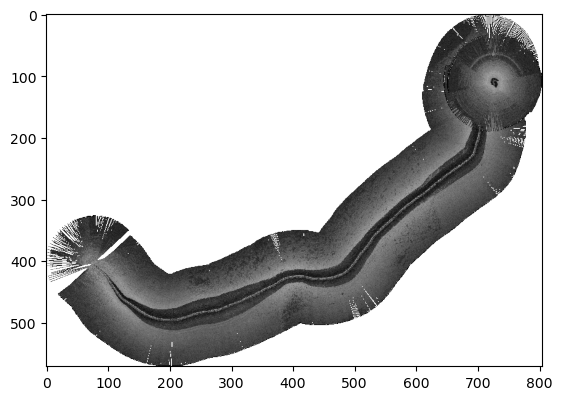

In [14]:
crs = "EPSG:4326"

# convert pillopw image to numpy array
image_data = np.flip(image, axis=0)

#img show
plt.imshow(image_data, cmap='gray')

In [12]:
import numpy as np
import rasterio
from rasterio.transform import from_bounds

# Define the pixel values and other metadata
crs = "EPSG:4326"  # Spatial reference system (e.g., WGS84)
min_lon, min_lat = your_min_longitude, your_min_latitude
max_lon, max_lat = your_max_longitude, your_max_latitude

# Define the geotransform based on the extreme longitude and latitude points
transform = from_bounds(min_lon, min_lat, max_lon, max_lat, width, height)

# Write the image data to a new GeoTIFF file
with rasterio.open(
    "output6.tif",
    "w",
    driver="GTiff",
    height=image_data.shape[0],
    width=image_data.shape[1],
    count=4,  # Number of bands (assuming a single-band image)
    dtype=image_data.dtype,  # Data type of the image (e.g., uint8)
    crs=crs,  # Spatial reference system
    transform=transform,  # Geotransform
) as dst:
    dst.write(image_data.transpose(2, 0, 1))

In [15]:
mosaic["z"].dtype

dtype('uint8')

In [41]:
data = sonar.df.query(f"survey == 'sidescan'")
dist = [np.linspace(start, stop, num = len(f)) for start, stop, f in zip(data["min_range"], data["max_range"], data["frames"])]

In [76]:
dist_stack = np.stack(dist)
sidescan_z = sonar.image("sidescan")

In [73]:
np.expand_dims(data["x"], axis=1)

array([[13413582],
       [13413582],
       [13413582],
       ...,
       [13414098],
       [13414098],
       [13414098]], dtype=int32)

In [67]:
sidescan_x = np.expand_dims(data["x"], axis=1) + dist_stack * np.cos(np.expand_dims(data["gps_heading"], axis=1))

In [74]:
np.expand_dims(data["x"], axis=1) + (dist_stack * np.cos(np.expand_dims(data["gps_heading"], axis=1)))

array([[13413639.08749291, 13413639.04670156, 13413639.00591021, ...,
        13413524.99408979, 13413524.95329844, 13413524.91250709],
       [13413639.63338485, 13413639.59220344, 13413639.55102203, ...,
        13413524.44897797, 13413524.40779656, 13413524.36661515],
       [13413640.08267505, 13413640.04117261, 13413639.99967016, ...,
        13413524.00032984, 13413523.95882739, 13413523.91732495],
       ...,
       [13414147.07667784, 13414147.04161055, 13414147.00654325, ...,
        13414048.99345675, 13414048.95838945, 13414048.92332216],
       [13414146.8690941 , 13414146.83417513, 13414146.79925616, ...,
        13414049.20074384, 13414049.16582487, 13414049.1309059 ],
       [13414146.67843399, 13414146.64365126, 13414146.60886853, ...,
        13414049.39113147, 13414049.35634874, 13414049.32156601]])

In [84]:
sidescan_df = pd.DataFrame({"x": sidescan_x.ravel(),
            "z": sidescan_z.ravel()})
sidescan_df

,x,z
0,1.341364e+07,44
1,1.341364e+07,42
2,1.341364e+07,31
3,1.341364e+07,33
4,1.341364e+07,29
...,...,...
11902795,1.341405e+07,2
11902796,1.341405e+07,96
11902797,1.341405e+07,91
11902798,1.341405e+07,172


In [85]:
sidescan_df["longitude"] = sonar._x2lon(sidescan_df["x"])
sidescan_df

,x,z,longitude
0,1.341364e+07,44,120.902132
1,1.341364e+07,42,120.902132
2,1.341364e+07,31,120.902131
3,1.341364e+07,33,120.902131
4,1.341364e+07,29,120.902131
...,...,...,...
11902795,1.341405e+07,2,120.905831
11902796,1.341405e+07,96,120.905831
11902797,1.341405e+07,91,120.905830
11902798,1.341405e+07,172,120.905830


In [81]:
sidescan_x.shape

(4251, 2800)

In [65]:
dist_stack * np.cos(np.expand_dims(data["gps_heading"], axis=1))

array([[ 57.08749291,  57.04670156,  57.00591021, ..., -57.00591021,
        -57.04670156, -57.08749291],
       [ 57.63338485,  57.59220344,  57.55102203, ..., -57.55102203,
        -57.59220344, -57.63338485],
       [ 58.08267505,  58.04117261,  57.99967016, ..., -57.99967016,
        -58.04117261, -58.08267505],
       ...,
       [ 49.07667784,  49.04161055,  49.00654325, ..., -49.00654325,
        -49.04161055, -49.07667784],
       [ 48.8690941 ,  48.83417513,  48.79925616, ..., -48.79925616,
        -48.83417513, -48.8690941 ],
       [ 48.67843399,  48.64365126,  48.60886853, ..., -48.60886853,
        -48.64365126, -48.67843399]])

In [64]:
np.cos(np.expand_dims(data["gps_heading"], axis=1))
-60.01511765 * -0.95121855

57.08749318911241

In [58]:
dist_stack * np.cos(np.expand_dims(data["gps_heading"], axis=1))

array([[ 57.08749291,  57.04670156,  57.00591021, ..., -57.00591021,
        -57.04670156, -57.08749291],
       [ 57.63338485,  57.59220344,  57.55102203, ..., -57.55102203,
        -57.59220344, -57.63338485],
       [ 58.08267505,  58.04117261,  57.99967016, ..., -57.99967016,
        -58.04117261, -58.08267505],
       ...,
       [ 49.07667784,  49.04161055,  49.00654325, ..., -49.00654325,
        -49.04161055, -49.07667784],
       [ 48.8690941 ,  48.83417513,  48.79925616, ..., -48.79925616,
        -48.83417513, -48.8690941 ],
       [ 48.67843399,  48.64365126,  48.60886853, ..., -48.60886853,
        -48.64365126, -48.67843399]])

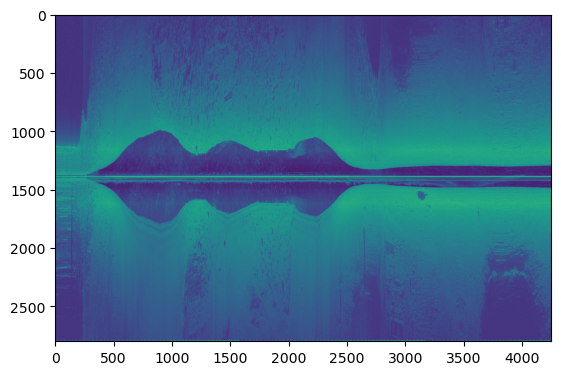

In [31]:
plt.imshow(sonar.image("sidescan").T)

In [105]:
mosaic

,x,y,z,longitude,latitude
0,1.341364e+07,1.533617e+06,44,120.902132,13.690881
1,1.341364e+07,1.533617e+06,42,120.902132,13.690880
2,1.341364e+07,1.533616e+06,31,120.902131,13.690880
3,1.341364e+07,1.533616e+06,33,120.902131,13.690880
4,1.341364e+07,1.533616e+06,29,120.902131,13.690880
...,...,...,...,...,...
11902795,1.341405e+07,1.533863e+06,2,120.905831,13.693039
11902796,1.341405e+07,1.533863e+06,96,120.905831,13.693039
11902797,1.341405e+07,1.533863e+06,91,120.905830,13.693040
11902798,1.341405e+07,1.533863e+06,172,120.905830,13.693040


/home/louis/miniconda3/envs/lowmapper/lib/python3.12/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


GeoTIFF saved to output.tif


In [9]:
sonar.water(channel="primary", pixels=3)

array([[116. ,  81.5, 159. ],
       [116. ,  82. , 157. ],
       [116. ,  80. , 149. ],
       ...,
       [216. , 130. , 194. ],
       [216. , 142. , 197. ],
       [216. , 122. , 185. ]])